In [ ]:
pip install optuna

In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

stock_data = yf.download('^NSEI')


num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy


# Here I choose to only use the last 3 years of stock data
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)

    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

[*********************100%%**********************]  1 of 1 completed


# XGBoost

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor
df_xgb = stock_data.copy()
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

[I 2024-04-13 07:15:23,943] A new study created in memory with name: no-name-ee2070d3-910f-4ecf-85b3-a3d43503759d
[I 2024-04-13 07:15:24,821] Trial 0 finished with value: 210.46419384491486 and parameters: {'n_estimators': 201, 'max_depth': 7, 'learning_rate': 0.07285738780525583, 'subsample': 0.9505162421678093, 'colsample_bytree': 0.834452083914115, 'reg_alpha': 9.660784006493454, 'reg_lambda': 3.3987872904784266}. Best is trial 0 with value: 210.46419384491486.
[I 2024-04-13 07:15:25,171] Trial 1 finished with value: 236.73985839904088 and parameters: {'n_estimators': 349, 'max_depth': 3, 'learning_rate': 0.07618535120143036, 'subsample': 0.82109592644684, 'colsample_bytree': 0.7079380500319505, 'reg_alpha': 8.78089431102701, 'reg_lambda': 6.373334276413148}. Best is trial 0 with value: 210.46419384491486.
[I 2024-04-13 07:15:25,620] Trial 2 finished with value: 231.99651506503884 and parameters: {'n_estimators': 498, 'max_depth': 3, 'learning_rate': 0.06994302458256092, 'subsample'

Best trial:
  Value: 176.08263223677832
  Params: 
    n_estimators: 985
    max_depth: 9
    learning_rate: 0.028647308652824402
    subsample: 0.7443724004886425
    colsample_bytree: 0.6477221902175315
    reg_alpha: 7.3775161663560995
    reg_lambda: 0.015102084123602394
Test RMSE: 176.08263223677832
ERROR PERCENT = 0.8792031517247787% 


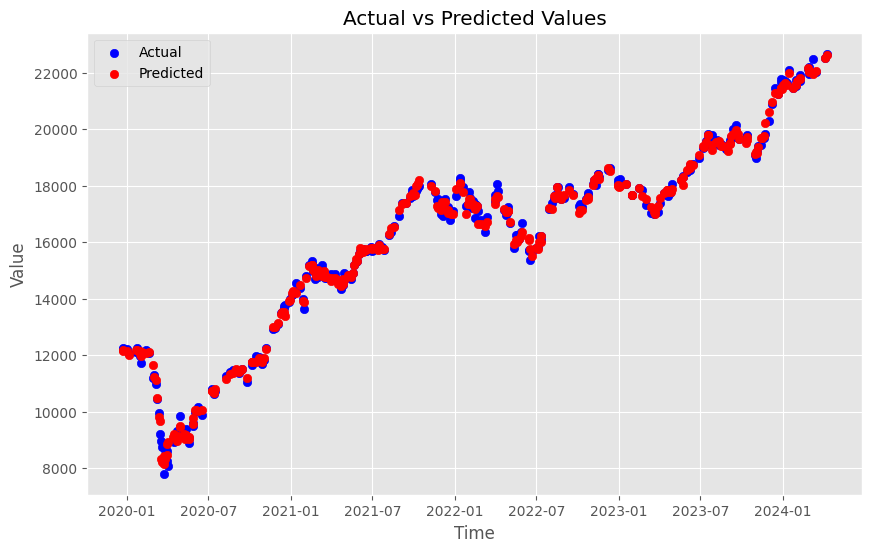

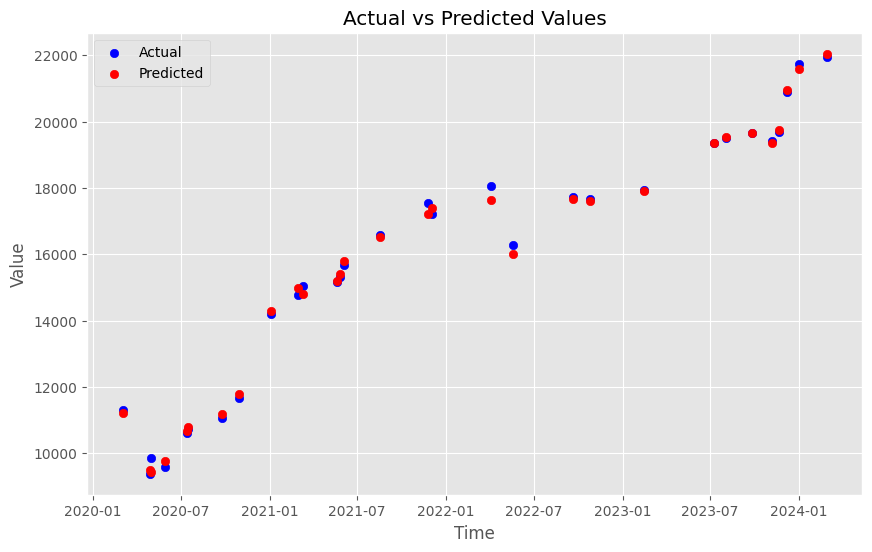

<Figure size 1000x600 with 0 Axes>

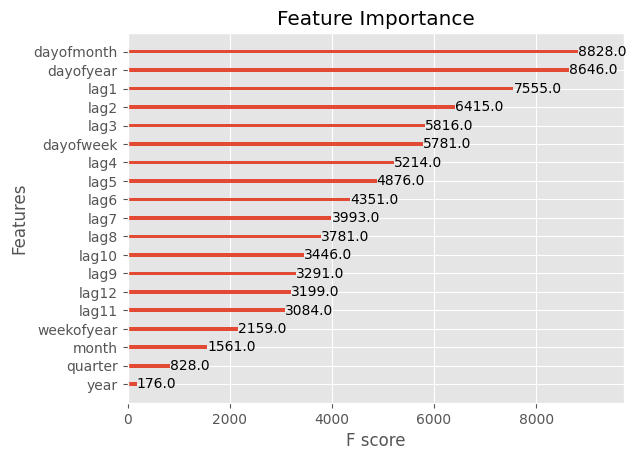

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()


In [ ]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-04-12,22375.583984
2024-04-13,22246.531250
2024-04-14,22356.351562
2024-04-15,22379.205078
2024-04-16,22352.597656
2024-04-17,22244.728516
2024-04-18,22336.363281
2024-04-19,22150.626953
2024-04-20,22326.322266
2024-04-21,22232.728516


# LightGBM

In [ ]:
pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna

df_lgb = stock_data.copy()

def lightgbm_model(df_lgb, add_lags, create_features, num_days_pred=num_days_pred):
    df_lgb = create_features(df_lgb)
    df_lgb = add_lags(df_lgb)

    X = df_lgb.drop(columns='Close')
    y = df_lgb['Close']
    return X, y

X, y = lightgbm_model(df_lgb, add_lags, create_features, num_days_pred=30)

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': -1,
    }

    # Initialize LightGBM regressor with the suggested parameters
    lgb_reg = lgb.LGBMRegressor(**param)

    # Fit the model on training data
    lgb_reg.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = lgb_reg.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
lgb_best = lgb.LGBMRegressor(**best_params)
lgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = lgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

# Calculate mean absolute percentage error on the test set
lgb_loss = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"ERROR PERCENT = {lgb_loss}% ")


[I 2024-04-13 07:17:31,683] A new study created in memory with name: no-name-f8aed112-7210-45d6-9843-de34f70bc187
[I 2024-04-13 07:17:31,798] Trial 0 finished with value: 252.62419106140797 and parameters: {'num_leaves': 30, 'max_depth': 6, 'learning_rate': 0.06749535739355712, 'subsample': 0.7162325549296448, 'colsample_bytree': 0.9570783198035764, 'reg_alpha': 7.671581033231237, 'reg_lambda': 7.6325372297260525}. Best is trial 0 with value: 252.62419106140797.
[I 2024-04-13 07:17:31,888] Trial 1 finished with value: 296.0482891814549 and parameters: {'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.042949328873439385, 'subsample': 0.6636780123453973, 'colsample_bytree': 0.6652472919094152, 'reg_alpha': 9.350570279256372, 'reg_lambda': 5.680370328618245}. Best is trial 0 with value: 252.62419106140797.
[I 2024-04-13 07:17:32,014] Trial 2 finished with value: 210.54238642676964 and parameters: {'num_leaves': 68, 'max_depth': 10, 'learning_rate': 0.09762673229561833, 'subsample': 0.

Best trial:
  Value: 210.54238642676964
  Params: 
    num_leaves: 68
    max_depth: 10
    learning_rate: 0.09762673229561833
    subsample: 0.7313276944555759
    colsample_bytree: 0.6751922305518991
    reg_alpha: 7.898964307371694
    reg_lambda: 0.11624616068220517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 19
[LightGBM] [Info] Start training from score 16255.891088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

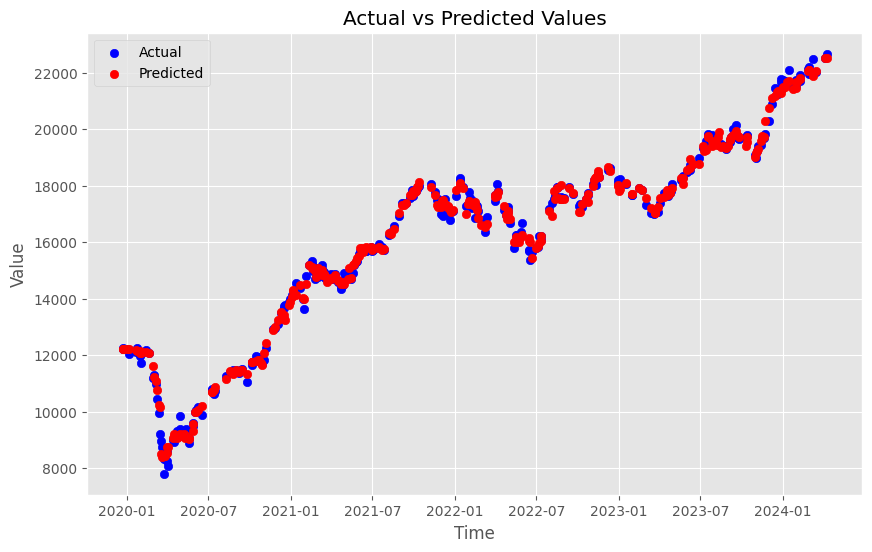

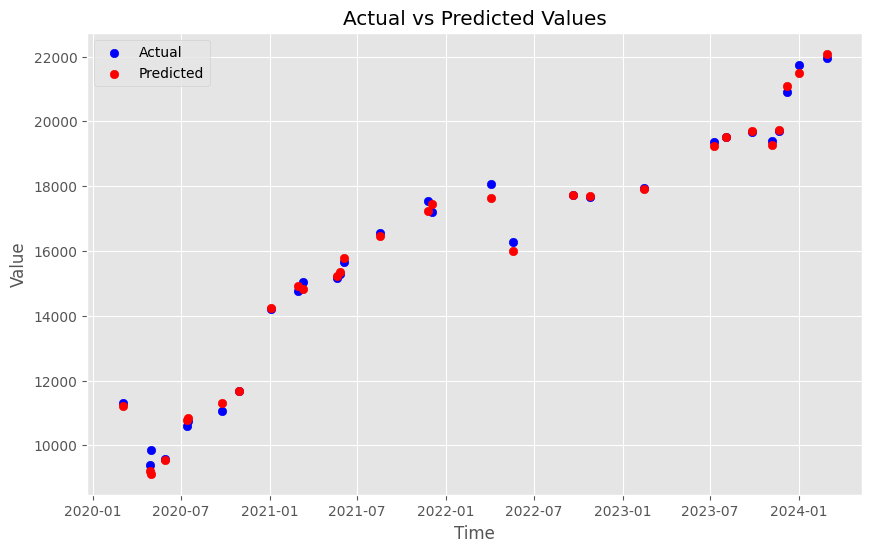

<Figure size 1000x600 with 0 Axes>

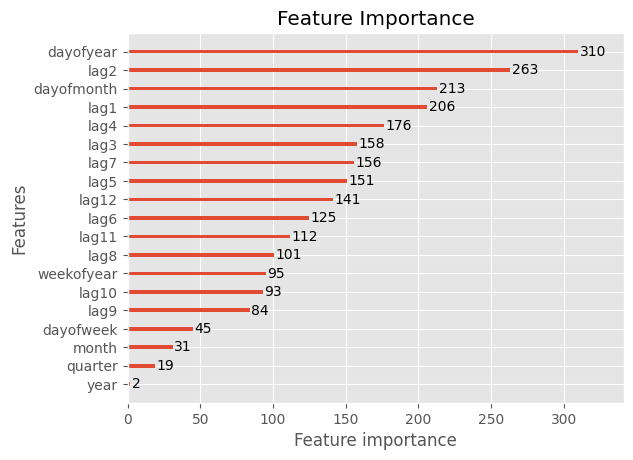

In [ ]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')  # Using y_pred_test from LightGBM
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Zooming in
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')  # Using y_pred_test from LightGBM
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot feature importance for LightGBM
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()


In [ ]:
# Generating predictions for future using LightGBM
start = df_lgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_lgb['isFuture'] = False
df_and_future = pd.concat([df_lgb, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

future_w_features['pred'] = lgb_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_lgb = pd.DataFrame(future_w_features['pred'])

# CatBoost

In [ ]:
pip install catboost

In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

# Define functions
def catboostmodel(df, add_lags, create_features, num_days_pred=num_days_pred):
    df = create_features(df)
    df = add_lags(df)

    X = df.drop(columns='Close')
    y = df['Close']
    return X, y

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'od_type': 'Iter',
        'od_wait': 25,
        'verbose': False
    }

    # Initialize CatBoost regressor with the suggested parameters
    catboost = CatBoostRegressor(**param)

    # Create pool object for training
    train_pool = Pool(X_train, label=y_train)

    # Fit the model on training data
    catboost.fit(train_pool)

    # Predict on the validation set
    y_pred = catboost.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse



In [ ]:
# Split data and perform feature engineering
df_catboost = stock_data.copy()
X, y = catboostmodel(df_catboost, add_lags, create_features, num_days_pred=30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
catboost_best = CatBoostRegressor(**best_params)
catboost_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = catboost_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-13 07:17:43,983] A new study created in memory with name: no-name-45f44def-8996-416e-b159-a72e3b14ef24
[I 2024-04-13 07:17:49,679] Trial 0 finished with value: 338.8285398267994 and parameters: {'iterations': 185, 'learning_rate': 0.02749159490685152, 'depth': 9, 'l2_leaf_reg': 1.07229451269785, 'random_strength': 3.0889676835993267, 'bagging_temperature': 9.363293574872285}. Best is trial 0 with value: 338.8285398267994.
[I 2024-04-13 07:18:15,436] Trial 1 finished with value: 263.1561596389629 and parameters: {'iterations': 820, 'learning_rate': 0.019232573653699882, 'depth': 9, 'l2_leaf_reg': 7.313091516131615, 'random_strength': 9.87754786452176, 'bagging_temperature': 8.759484782848952}. Best is trial 1 with value: 263.1561596389629.
[I 2024-04-13 07:18:21,909] Trial 2 finished with value: 229.63313543578272 and parameters: {'iterations': 997, 'learning_rate': 0.08977542380820872, 'depth': 5, 'l2_leaf_reg': 6.986218168979238, 'random_strength': 6.039848184101152, 'baggi

Best trial:
  Value: 191.98368259912448
  Params: 
    iterations: 726
    learning_rate: 0.05131308884422592
    depth: 8
    l2_leaf_reg: 3.8104853582226084
    random_strength: 0.13349842300893813
    bagging_temperature: 0.2537820062252802
0:	learn: 3207.9713626	total: 18ms	remaining: 13.1s
1:	learn: 3065.6698845	total: 34.9ms	remaining: 12.7s
2:	learn: 2927.8913317	total: 45.6ms	remaining: 11s
3:	learn: 2797.8873555	total: 55.7ms	remaining: 10.1s
4:	learn: 2676.8843847	total: 65.6ms	remaining: 9.46s
5:	learn: 2558.7223187	total: 76.2ms	remaining: 9.15s
6:	learn: 2447.6960462	total: 87.8ms	remaining: 9.02s
7:	learn: 2339.7085385	total: 99.7ms	remaining: 8.95s
8:	learn: 2236.8363771	total: 110ms	remaining: 8.78s
9:	learn: 2139.1376822	total: 121ms	remaining: 8.65s
10:	learn: 2046.7679279	total: 132ms	remaining: 8.56s
11:	learn: 1956.7468440	total: 142ms	remaining: 8.46s
12:	learn: 1872.0767763	total: 153ms	remaining: 8.4s
13:	learn: 1788.9880105	total: 164ms	remaining: 8.32s
14:	lea

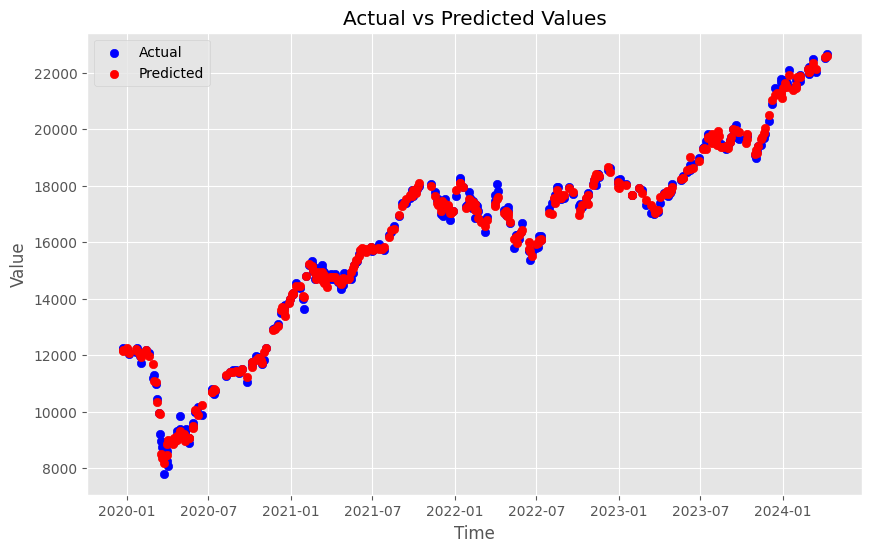

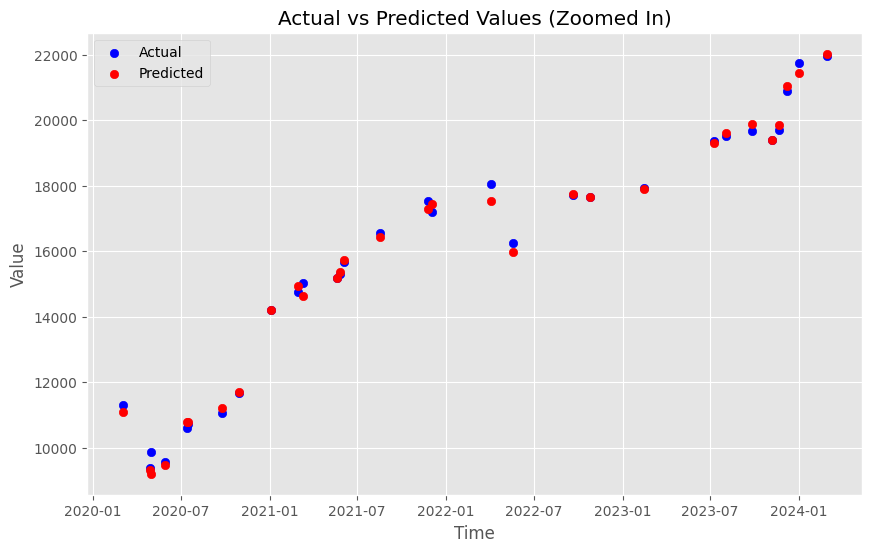

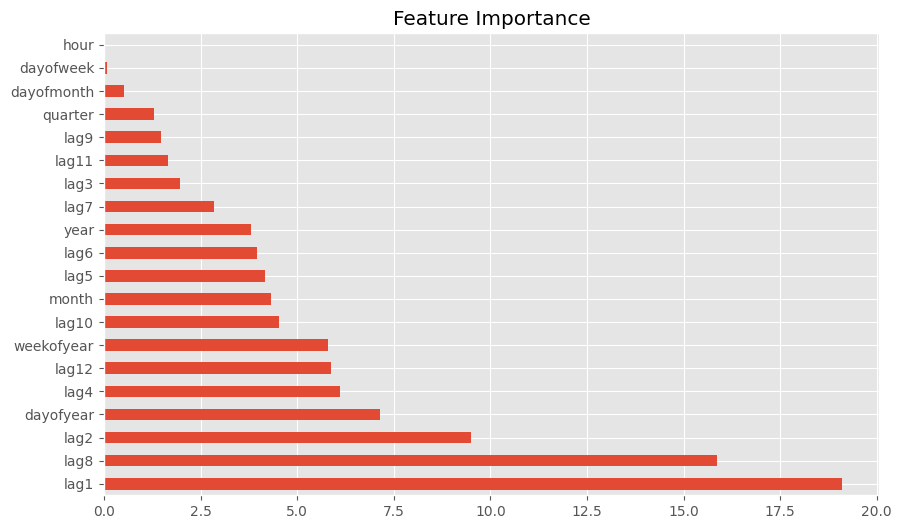

In [ ]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Actual vs Predicted Values (Zoomed In)
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(catboost_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importance")
plt.show()


In [ ]:
# Predict future values
start = df_catboost.index.max()
end = start + pd.Timedelta(days=num_days_pred)
future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_catboost['isFuture'] = False
df_and_future = pd.concat([df_catboost, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = catboost_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_catboost = pd.DataFrame(future_w_features['pred'])
prediction_catboost

,pred
2024-04-12,22478.818773
2024-04-13,22504.187198
2024-04-14,22460.420180
2024-04-15,22418.379098
2024-04-16,22395.379129
2024-04-17,22337.849628
2024-04-18,22266.414305
2024-04-19,22191.955917
2024-04-20,22244.440701
2024-04-21,22187.850123


# HistGradientBoostingRegressor

In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt

# Define functions
def gbm_model(df, add_lags, create_features, num_days_pred=num_days_pred):
    df = create_features(df)
    df = add_lags(df)

    X = df.drop(columns='Close')
    y = df['Close']
    return X, y

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'max_iter': trial.suggest_int('max_iter', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Initialize HistGradientBoostingRegressor with the suggested parameters
    gbm = HistGradientBoostingRegressor(**param)

    # Fit the model on training data
    gbm.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = gbm.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


In [ ]:
# Split data and perform feature engineering
df_gbm = stock_data.copy()
X, y = gbm_model(df_gbm, add_lags, create_features, num_days_pred=30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params

# Initialize HistGradientBoostingRegressor with the best parameters
gbm_best = HistGradientBoostingRegressor(**best_params)

# Fit the model on training data
gbm_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = gbm_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-13 07:21:47,010] A new study created in memory with name: no-name-3fc0ac09-e7f6-4855-b504-ff060f6fb660
[I 2024-04-13 07:21:50,457] Trial 0 finished with value: 309.51598607604404 and parameters: {'max_iter': 670, 'learning_rate': 0.703454818000374, 'max_depth': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 309.51598607604404.
[I 2024-04-13 07:21:51,219] Trial 1 finished with value: 250.49312334261631 and parameters: {'max_iter': 151, 'learning_rate': 0.44357481023873846, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 250.49312334261631.
[I 2024-04-13 07:21:52,906] Trial 2 finished with value: 244.85195577617074 and parameters: {'max_iter': 383, 'learning_rate': 0.3153483428538852, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 244.85195577617074.
[I 2024-04-13 07:21:56,395] Trial 3 finished with value: 234.4951539826123 and parameters: {'max_iter': 866, 'learning_rate': 0.33045671762982376, 'max_depth': 10, 'min_samples_le

Best trial:
  Value: 221.4370748279403
  Params: 
    max_iter: 271
    learning_rate: 0.027401344275698306
    max_depth: 8
    min_samples_leaf: 4
Test RMSE: 221.4370748279403


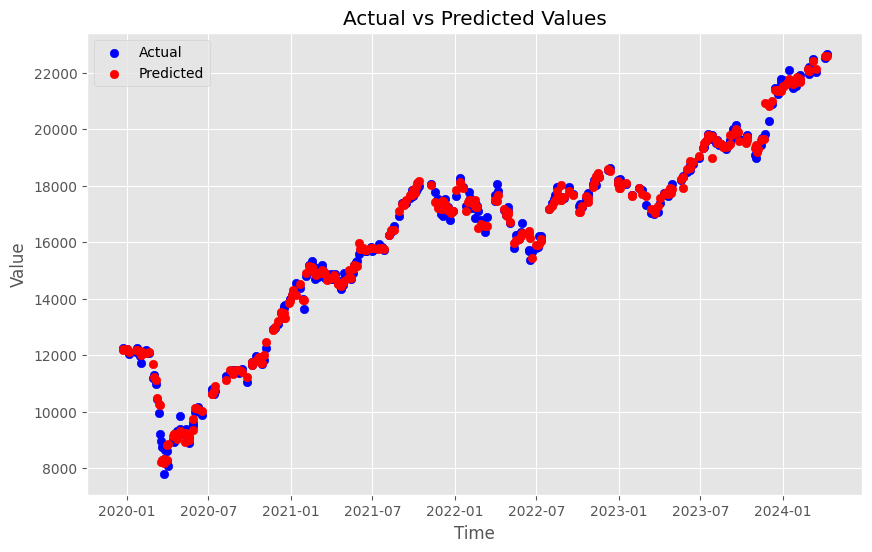

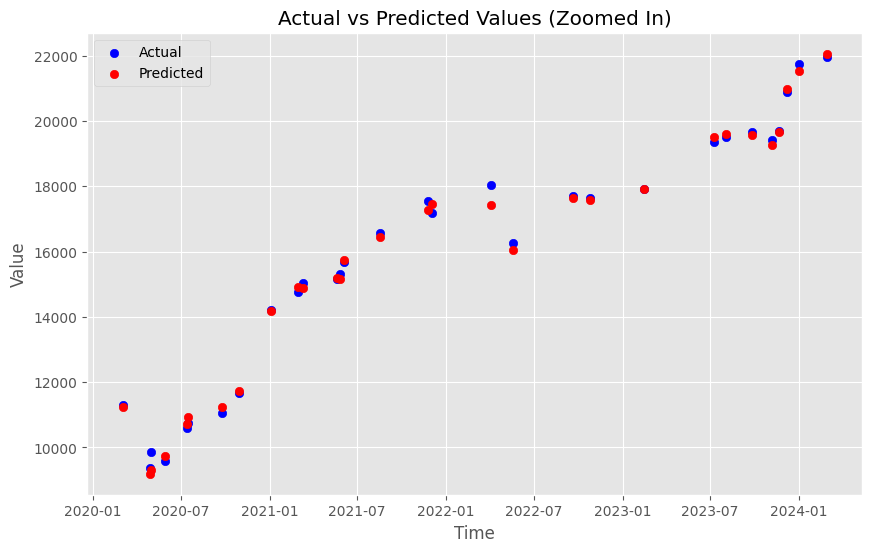

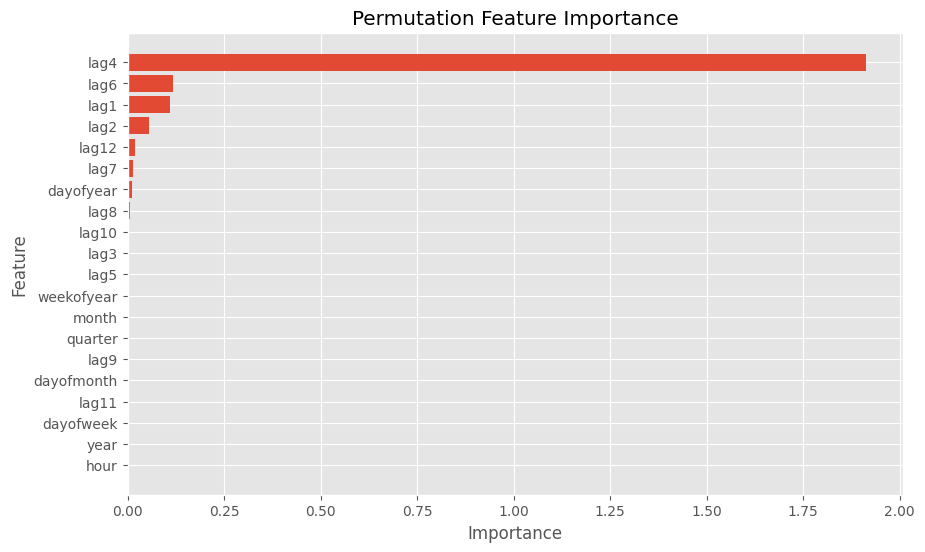

In [ ]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Actual vs Predicted Values (Zoomed In)
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test[:30], color='red', label='Predicted')
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate permutation importance
result = permutation_importance(gbm_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get sorted feature indices by importance
sorted_idx = result.importances_mean.argsort()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Predict future values
start = df_gbm.index.max()
end = start + pd.Timedelta(days=num_days_pred)
future = pd.date_range(start=start, end=end, freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_gbm['isFuture'] = False
df_and_future = pd.concat([df_gbm, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = gbm_best.predict(future_w_features.drop(columns=['Close', 'isFuture']))
prediction_gbm = pd.DataFrame(future_w_features['pred'])
prediction_gbm

,pred
2024-04-12,22380.818182
2024-04-13,22375.578778
2024-04-14,22521.890270
2024-04-15,22532.788654
2024-04-16,22478.144143
2024-04-17,22415.004734
2024-04-18,22387.993280
2024-04-19,22141.514887
2024-04-20,22139.603449
2024-04-21,22408.946434


# Results

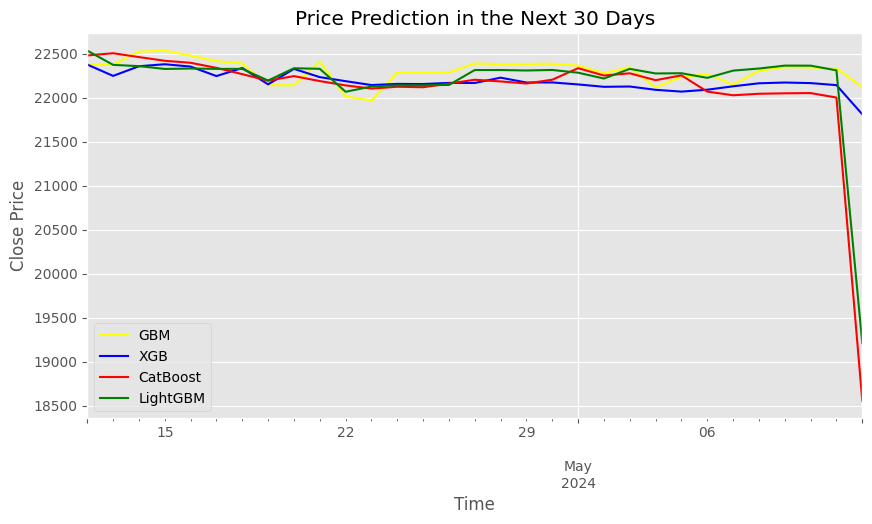

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
prediction_gbm.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
prediction_catboost.plot(color = 'red',ax=ax)
prediction_lgb.plot(color = 'green',ax=ax)
plt.legend(['GBM','XGB','CatBoost', 'LightGBM'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");
